# This is a solution of Overnight Finance Challenge: ETH/USDC Predictions https://www.notion.so/Overnight-Finance-Challenge-ETH-USDC-Predictions-25a2ab88fe6380f996e7c61fc9a9e036

## Author: Rybkin Makar

## Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

sns.set_style("whitegrid")

df_clear = pd.read_csv("/kaggle/input/overnight-challenge/train.csv/train.csv")
df = df_clear.copy()
df = df.sort_values('local_timestamp').reset_index(drop=True)

df['mid_price'] = (df['bid_price_1'] + df['ask_price_1']) / 2
df['spread'] = df['ask_price_1'] - df['bid_price_1']
df['imbalance_L1'] = (df['bid_qty_1'] - df['ask_qty_1']) / (df['bid_qty_1'] + df['ask_qty_1'])
df['log_ret'] = np.log(df['mid_price']).diff()

print(f"Dataset shape for EDA: {df.shape}")

Dataset shape for EDA: (2218127, 86)


## Class Distribution Analisys

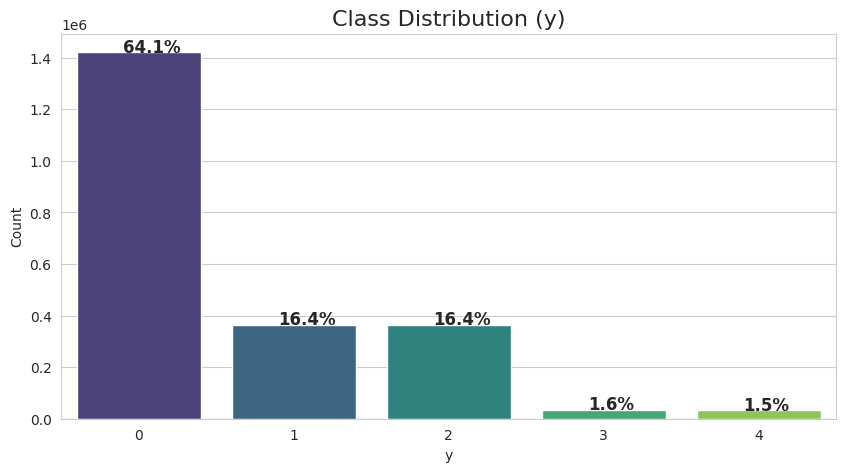

In [2]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=df['y'], palette='viridis')
plt.title('Class Distribution (y)', fontsize=16)
plt.ylabel('Count')

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_height()
    ax.annotate(percentage, (x, y), fontsize=12, fontweight='bold')

plt.show()

## These are 4 classes 0 - Neutral, 1 - Weak Down, 2 - Weak Up, 3 - Strong Down, 4 - Strong Up 
## It has been experimentally established that the target price most likely represents future returns after 40 ticks.

In [24]:
df['future_ret_40'] = np.log(df['mid_price'].shift(-40) / df['mid_price'])

print("Mid return after 40 ticks for every class:")
print(df.groupby('y')['future_ret_40'].mean())

Mid return after 40 ticks for every class:
y
0   -8.822290e-09
1   -1.797556e-04
2    1.803141e-04
3   -5.373970e-04
4    5.363759e-04
Name: future_ret_40, dtype: float64


## Average Order Book Levels

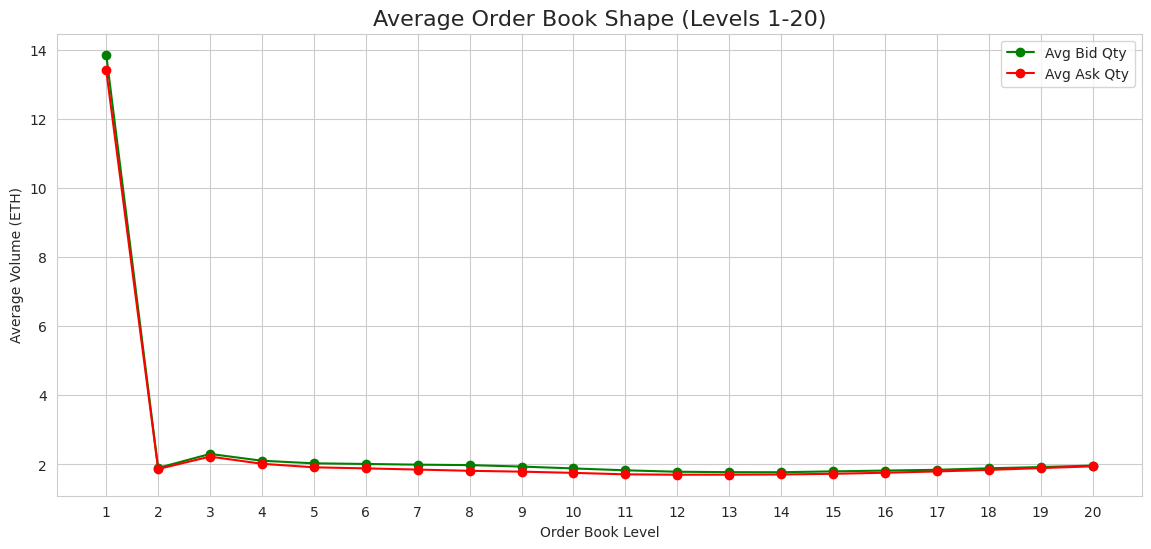

In [25]:
levels = range(1, 21)
avg_bid_qty = [df[f'bid_qty_{i}'].mean() for i in levels]
avg_ask_qty = [df[f'ask_qty_{i}'].mean() for i in levels]

plt.figure(figsize=(14, 6))
plt.plot(levels, avg_bid_qty, label='Avg Bid Qty', marker='o', color='green')
plt.plot(levels, avg_ask_qty, label='Avg Ask Qty', marker='o', color='red')
plt.title('Average Order Book Shape (Levels 1-20)', fontsize=16)
plt.xlabel('Order Book Level')
plt.ylabel('Average Volume (ETH)')
plt.xticks(levels)
plt.legend()
plt.show()


## L1_imabalance vs Target Boxplots

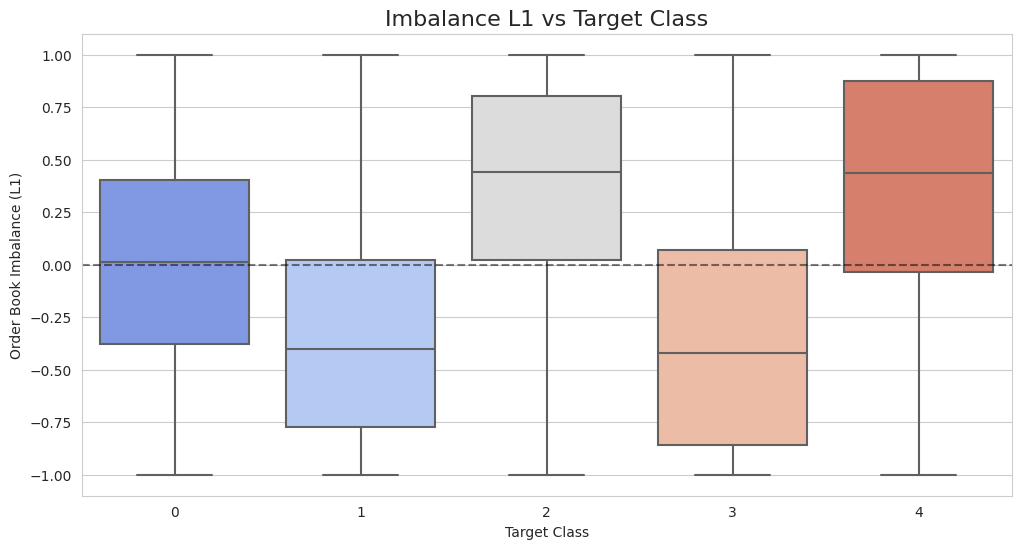

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='y', y='imbalance_L1', data=df, palette='coolwarm', showfliers=False)
plt.title('Imbalance L1 vs Target Class', fontsize=16)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Target Class')
plt.ylabel('Order Book Imbalance (L1)')
plt.show()

## Train price chart

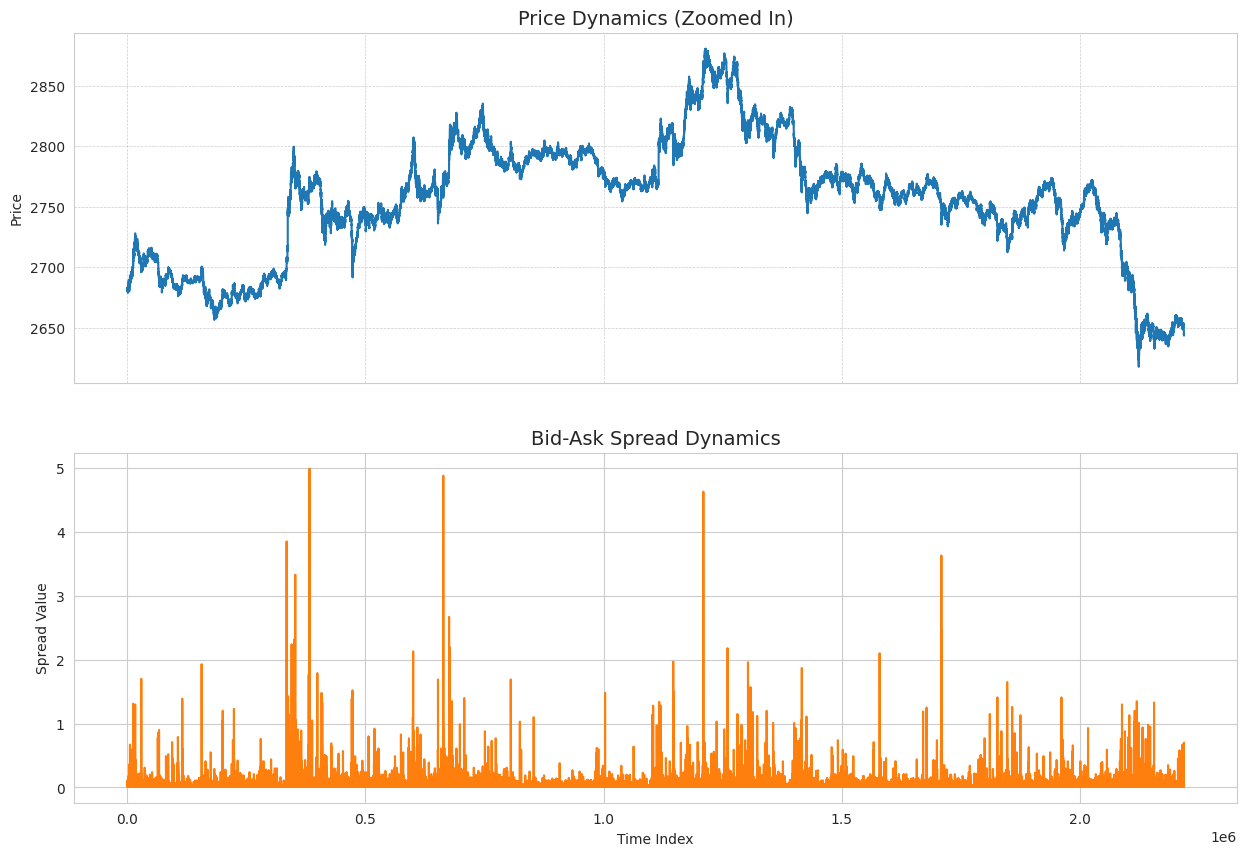

In [28]:
subset = df

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

ax1.plot(subset.index, subset['mid_price'], label='Mid Price', color='#1f77b4')
ax1.set_title('Price Dynamics (Zoomed In)', fontsize=14)
ax1.set_ylabel('Price')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

ax2.plot(subset.index, subset['spread'], label='Bid-Ask Spread', color='#ff7f0e')
ax2.set_title('Bid-Ask Spread Dynamics', fontsize=14)
ax2.set_ylabel('Spread Value')
ax2.set_xlabel('Time Index')

plt.show()

## Log_ret distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


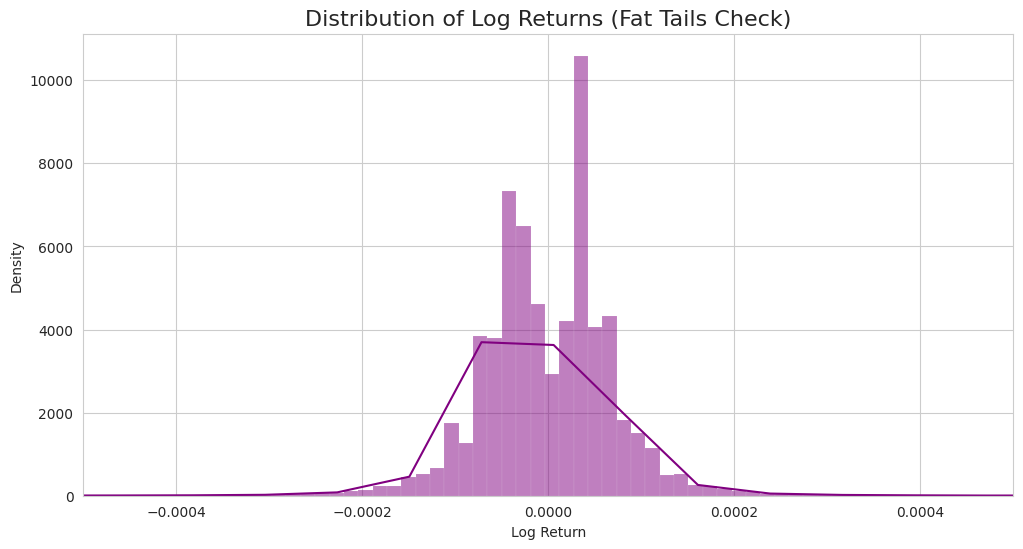

In [31]:
plt.figure(figsize=(12, 6))
returns = df['log_ret'].dropna()
returns = returns[returns != 0] 

sns.histplot(returns, bins=1000, kde=True, stat="density", color="purple")
plt.title('Distribution of Log Returns (Fat Tails Check)', fontsize=16)
plt.xlim(-0.0005, 0.0005) 
plt.xlabel('Log Return')
plt.show()


## ACF

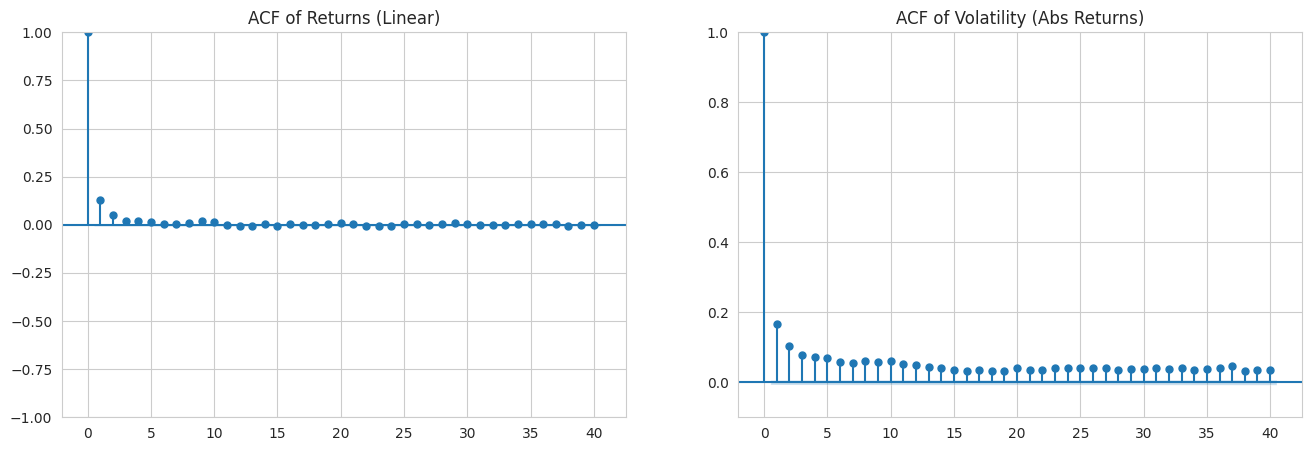


1. The ACF of returns (left) is usually near zero. This means it's difficult to predict the price linearly.
2. The ACF of volatility (right) usually declines slowly. This means that if there's a storm now,
there will be a storm in a second. This is an IMPORTANT feature: volatility_rolling is a must-have.



In [2]:
from statsmodels.graphics.tsaplots import plot_acf

subset_ret = df['log_ret'].replace([np.inf, -np.inf], np.nan).dropna().iloc[:100000]
subset_vol = df['log_ret'].abs().replace([np.inf, -np.inf], np.nan).dropna().iloc[:100000]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(subset_ret, lags=40, ax=ax1, title='ACF of Returns (Linear)', auto_ylims=False)

plot_acf(subset_vol, lags=40, ax=ax2, title='ACF of Volatility (Abs Returns)', auto_ylims=False)
ax2.set_ylim(-0.1, 1.0) 

plt.show()

print("""
1. The ACF of returns (left) is usually near zero. This means it's difficult to predict the price linearly.
2. The ACF of volatility (right) usually declines slowly. This means that if there's a storm now,
there will be a storm in a second. This is an IMPORTANT feature: volatility_rolling is a must-have.
""")

## Average Price Path after Signal

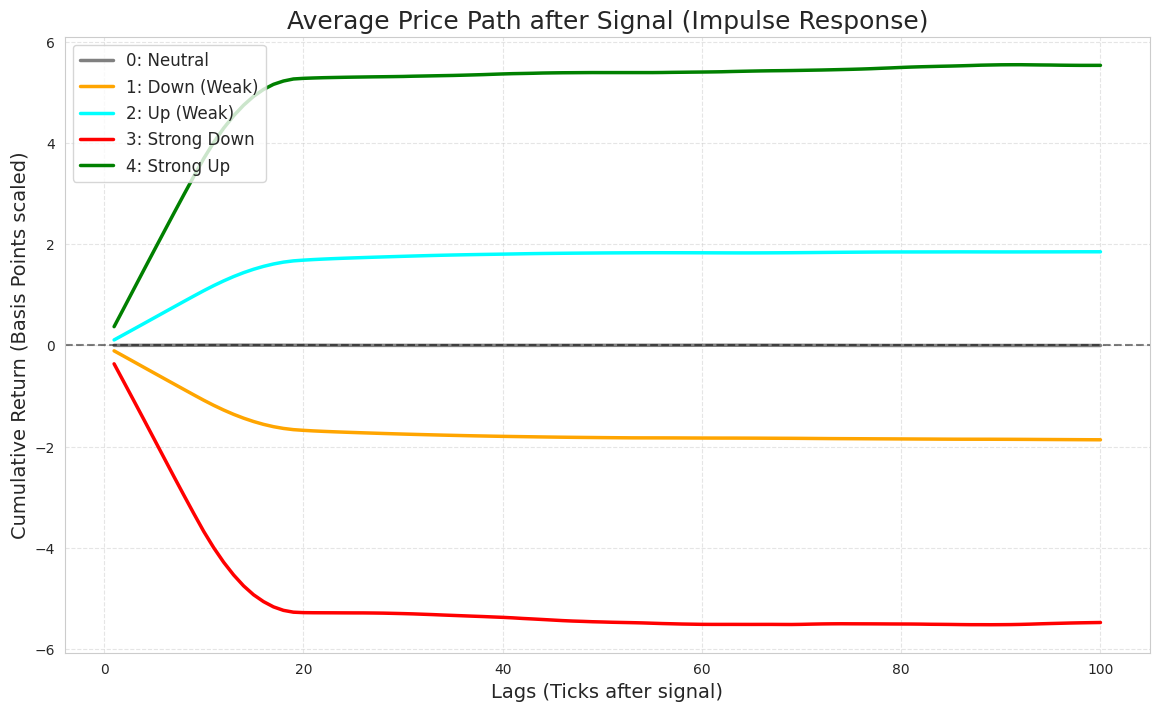

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


horizon = 100  
lags = range(1, horizon + 1)

impulse_data = {c: [] for c in [0, 1, 2, 3, 4]}
x_axis = list(lags)

for lag in lags:

    ret = np.log(df['mid_price'].shift(-lag) / df['mid_price'])
    means = df.groupby('y')[ret.name].mean() 
    temp_df = pd.DataFrame({'y': df['y'], 'ret': ret})
    means = temp_df.groupby('y')['ret'].mean()
    
    for c in [0, 1, 2, 3, 4]:
        if c in means.index:
            impulse_data[c].append(means[c])
        else:
            impulse_data[c].append(0)

plt.figure(figsize=(14, 8))
colors = {0: 'gray', 1: 'orange', 2: 'cyan', 3: 'red', 4: 'green'}
labels = {
    0: '0: Neutral', 
    1: '1: Down (Weak)', 
    2: '2: Up (Weak)', 
    3: '3: Strong Down', 
    4: '4: Strong Up'
}

for c in [0, 1, 2, 3, 4]:
    y_vals = np.array(impulse_data[c]) * 10000 
    plt.plot(x_axis, y_vals, label=labels[c], color=colors[c], linewidth=2.5)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Average Price Path after Signal (Impulse Response)', fontsize=18)
plt.xlabel('Lags (Ticks after signal)', fontsize=14)
plt.ylabel('Cumulative Return (Basis Points scaled)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

## Train Catboost on all features

In [3]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.cluster import MiniBatchKMeans
import gc

def calculate_multilevel_ofi_raw(df, levels=5, decay_rate=0.8):
    """
    Returns a single raw weighted Order Flow Imbalance (OFI) series
    computed across multiple order book levels.
    """
    total_ofi = pd.Series(0.0, index=df.index)
    weights = [decay_rate ** i for i in range(levels)]
    
    for i in range(levels):
        level = i + 1
        if f'bid_price_{level}' not in df.columns:
            break
            
        curr_bp = df[f'bid_price_{level}']
        curr_bq = df[f'bid_qty_{level}']
        curr_ap = df[f'ask_price_{level}']
        curr_aq = df[f'ask_qty_{level}']
        
        prev_bp = curr_bp.shift(1)
        prev_bq = curr_bq.shift(1)
        prev_ap = curr_ap.shift(1)
        prev_aq = curr_aq.shift(1)
        
        bid_flow = np.zeros(len(df))
        bid_flow = np.where(curr_bp > prev_bp, curr_bq, bid_flow)
        bid_flow = np.where(curr_bp < prev_bp, -prev_bq, bid_flow)
        bid_flow = np.where(curr_bp == prev_bp, curr_bq - prev_bq, bid_flow)
        
        ask_flow = np.zeros(len(df))
        ask_flow = np.where(curr_ap > prev_ap, -prev_aq, ask_flow)
        ask_flow = np.where(curr_ap < prev_ap, curr_aq, ask_flow)
        ask_flow = np.where(curr_ap == prev_ap, curr_aq - prev_aq, ask_flow)
        
        total_ofi += (bid_flow - ask_flow) * weights[i]
        
    return total_ofi.fillna(0)

def calculate_cog_features(df, levels=5):
    """
    Computes liquidity center-of-gravity (COG) distances
    relative to best bid / ask.
    """
    sum_bid_px_qty = 0
    sum_bid_qty = 0
    sum_ask_px_qty = 0
    sum_ask_qty = 0
    
    for i in range(1, levels + 1):
        if f'bid_price_{i}' not in df.columns: break
            
        p_bid = df[f'bid_price_{i}']
        q_bid = df[f'bid_qty_{i}']
        sum_bid_px_qty += p_bid * q_bid
        sum_bid_qty += q_bid
        
        p_ask = df[f'ask_price_{i}']
        q_ask = df[f'ask_qty_{i}']
        sum_ask_px_qty += p_ask * q_ask
        sum_ask_qty += q_ask
        
    sum_bid_qty = sum_bid_qty.replace(0, np.nan)
    sum_ask_qty = sum_ask_qty.replace(0, np.nan)
    
    bid_cog = sum_bid_px_qty / sum_bid_qty
    ask_cog = sum_ask_px_qty / sum_ask_qty

    bid_dist = df['bid_price_1'] - bid_cog
    ask_dist = ask_cog - df['ask_price_1']
    cog_pressure = ask_dist - bid_dist
    
    return pd.DataFrame({
        'bid_dist': bid_dist.fillna(0),
        'ask_dist': ask_dist.fillna(0),
        'cog_pressure': cog_pressure.fillna(0)
    })
def make_hft_features_final(df):
    """
    Full HFT feature pipeline based on order book, microstructure,
    volatility, imbalance, pressure and regime features.
    """
    df_feat = df.copy()

    # Order Flow & Liquidity
    mid_price = (df_feat['bid_price_1'] + df_feat['ask_price_1']) / 2
    df_feat['mid_price'] = mid_price

    # Weighted mid price
    df_feat['ofi_deep_raw'] = calculate_multilevel_ofi_raw(df_feat, levels=20, decay_rate=0.9)
    cog_feats = calculate_cog_features(df_feat, levels=20) 
    df_feat = pd.concat([df_feat, cog_feats], axis=1)

    df_feat['wmp'] = (df_feat['bid_price_1'] * df_feat['ask_qty_1'] + df_feat['ask_price_1'] * df_feat['bid_qty_1']) / (df_feat['bid_qty_1'] + df_feat['ask_qty_1'])    
    
    # Depth & density
    bid_vol_5 = df_feat[[f'bid_qty_{i}' for i in range(1, 6)]].sum(axis=1)
    ask_vol_5 = df_feat[[f'ask_qty_{i}' for i in range(1, 6)]].sum(axis=1)
    
    df_feat['bid_density'] = df_feat['bid_qty_1'] / (bid_vol_5 + 1e-6)
    df_feat['ask_density'] = df_feat['ask_qty_1'] / (ask_vol_5 + 1e-6)
    df_feat['density_imb'] = df_feat['bid_density'] - df_feat['ask_density']

    # Volume imbalance
    bid_vol_10 = df_feat[[f'bid_qty_{i}' for i in range(1, 11)]].sum(axis=1)
    ask_vol_10 = df_feat[[f'ask_qty_{i}' for i in range(1, 11)]].sum(axis=1)

    df_feat['imb_L1'] = (df_feat['bid_qty_1'] - df_feat['ask_qty_1']) / (df_feat['bid_qty_1'] + df_feat['ask_qty_1'])
    df_feat['log_imb_L1'] = np.log(df_feat['bid_qty_1']) - np.log(df_feat['ask_qty_1'])

    df_feat['imb_L10'] = (bid_vol_10 - ask_vol_10) / (bid_vol_10 + ask_vol_10)
    
    # Returns & spread
    df_feat['log_ret'] = np.log(df_feat['mid_price']).diff()
    df_feat['spread'] = (df_feat['ask_price_1'] - df_feat['bid_price_1']) / mid_price
    
    # Volatility, RSI, momentum
    for w in [10, 50, 100]:
        df_feat[f'vol_{w}'] = df_feat['log_ret'].rolling(w).std()
        
        r = df_feat['log_ret']
        up = r.clip(lower=0)
        down = -r.clip(upper=0)
        roll_up = up.rolling(w).mean()
        roll_down = down.rolling(w).mean()
        df_feat[f'rsi_{w}'] = roll_up / (roll_up + roll_down + 1e-9)
        
        ma = mid_price.rolling(w).mean()
        df_feat[f'price_div_{w}'] = (mid_price - ma) / (df_feat[f'vol_{w}'] + 1e-9)
        
    for w in [3, 5, 10, 15, 20, 30, 50]:
        
        df_feat[f'vol_{w}'] = df_feat['log_ret'].rolling(w).std()
        df_feat[f'ret_{w}'] = df_feat['log_ret'].rolling(w).sum()
        df_feat[f'imb_mean_{w}'] = df_feat['imb_L1'].rolling(w).mean()
        df_feat[f'imb_chg_{w}'] = df_feat['log_imb_L1'].diff(w)
    
        df_feat[f'ofi_deep_sum_{w}'] = df_feat['ofi_deep_raw'].rolling(w).sum()
        df_feat[f'cog_pressure_mean_{w}'] = df_feat['cog_pressure'].rolling(w).mean()
        df_feat[f'bid_dist_chg_{w}'] = df_feat['bid_dist'].diff(w)

    df_feat['imb_x_spread'] = df_feat['log_imb_L1'] * df_feat['spread']
    df_feat['ofi_x_vol'] = df_feat['ofi_deep_raw'] * df_feat['vol_50']
    df_feat['spread_ma_50'] = df_feat['spread'].rolling(50).mean()
    df_feat['spread_shock'] = df_feat['spread'] / df_feat['spread_ma_50']

    df_feat['spread_vol_20'] = df_feat['spread'].rolling(20).std()
    
    # Lagged microstructure
    cols_to_lag = ['log_ret', 'spread_shock', 'log_imb_L1','ofi_deep_raw', 'cog_pressure', 'rsi_10']
    for col in cols_to_lag:
        for lag in [1, 3, 5, 10, 20]:
            df_feat[f'{col}_lag_{lag}'] = df_feat[col].shift(lag)
    r = df_feat['log_ret']
    
    # Price acceleration (2nd derivative)
    df_feat['accel'] = r.diff()
    
    # Sudden L1 liquidity change
    df_feat['liq_shock_bid'] = df_feat['bid_qty_1'].diff()
    df_feat['liq_shock_ask'] = df_feat['ask_qty_1'].diff()
    df_feat['liq_shock'] = df_feat['liq_shock_bid'] + df_feat['liq_shock_ask']
    
    # Short-term price momentum
    df_feat['ret1'] = mid_price.diff()
    df_feat['ret2'] = mid_price.diff(2)
    df_feat['ret5'] = mid_price.diff(5)
    
    # Deep book pressure change (normalized)
    df_feat['deep_ofi'] = (bid_vol_10 - ask_vol_10).diff()
    df_feat['deep_ofi_norm'] = df_feat['deep_ofi'] / (bid_vol_10 + ask_vol_10 + 1e-9)
    
    # Local price range
    df_feat['rng'] = mid_price.rolling(10).max() - mid_price.rolling(10).min()
    
    # Low-movement / compression regime
    df_feat['stuck'] = (df_feat['ret1'].abs()+ df_feat['ret5'].abs()+ df_feat['spread']).rolling(20).sum()


    # L1 vs L2 size imbalance 
    df_feat['bid_spoof'] = df_feat['bid_qty_1'] / (df_feat['bid_qty_2'] + 1e-6)
    df_feat['ask_spoof'] = df_feat['ask_qty_1'] / (df_feat['ask_qty_2'] + 1e-6)
    df_feat['spoof_imb'] = df_feat['bid_spoof'] - df_feat['ask_spoof']
    
    # Impulse vs recent trend
    df_feat['ret_ratio'] = df_feat['ret1'] / (df_feat['ret5'].abs() + 1e-9)
    
    # Imbalance scaled by spread
    df_feat['imb_norm'] = df_feat['imb_L1'] / (df_feat['spread'] + 1e-6)
    
    # Deep book dominance
    df_feat['depth_ratio'] = (bid_vol_10 + 1) / (ask_vol_10 + 1)
    
    bid_tilt = 0
    ask_tilt = 0
    mid = df_feat['mid_price']
    
    for i in range(1, 21):
        bid_tilt += (df_feat[f'bid_price_{i}'] - mid) * df_feat[f'bid_qty_{i}']
        ask_tilt += (df_feat[f'ask_price_{i}'] - mid) * df_feat[f'ask_qty_{i}']
        
    # Weighted book tilt vs mid
    df_feat['tilt'] = bid_tilt - ask_tilt
    
    # Queue size imbalance
    df_feat['queue_imb'] = df_feat['bid_qty_1'] / (df_feat['bid_qty_1'] + df_feat['ask_qty_1'] + 1e-6)
    
    # # Book shape dynamics
    # df_feat['ask_slope_chg']= df_feat['ask_slope'].diff()
    # df_feat['bid_slope_chg'] = df_feat['bid_slope'].diff()
    # df_feat['slope_chg_imb'] = df_feat['bid_slope_chg'] - df_feat['ask_slope_chg']

    # Deep imbalance volatility
    df_feat['depth_imb_vol'] = df_feat['imb_L10'].rolling(10).std()
    
    # Spread compression / expansion
    df_feat['spread_comp'] = df_feat['spread'] / (df_feat['spread'].rolling(50).mean() + 1e-9)

    # Pressure × volatility
    df_feat['energy'] = df_feat['ofi_deep_raw'] * df_feat['vol_20']
    df_feat['energy_chg'] = df_feat['energy'].diff()

    # Queue persistence imbalance
    df_feat['bid_age'] = (df_feat['bid_qty_1']==df_feat['bid_qty_1'].shift(1)).astype(int).rolling(20).sum()
    df_feat['ask_age'] = (df_feat['ask_qty_1']==df_feat['ask_qty_1'].shift(1)).astype(int).rolling(20).sum()
    df_feat['age_imb'] = df_feat['bid_age'] - df_feat['ask_age']

    # Queue consumption speed
    df_feat['burn_bid'] = df_feat['bid_qty_1'].rolling(3).min() / (df_feat['bid_qty_1'].shift(3) + 1e-6)
    df_feat['burn_ask'] = df_feat['ask_qty_1'].rolling(3).min() / (df_feat['ask_qty_1'].shift(3) + 1e-6)
    df_feat['burn_imb'] = df_feat['burn_bid'] - df_feat['burn_ask']

    # Passive liquidity absorption
    df_feat['absorb_bid'] = (df_feat['bid_qty_1'].shift(1) - df_feat['bid_qty_1']).clip(lower=0)
    df_feat['absorb_ask'] = (df_feat['ask_qty_1'].shift(1) - df_feat['ask_qty_1']).clip(lower=0)
    df_feat['absorption_imb'] = df_feat['absorb_bid'] - df_feat['absorb_ask']
    
    # Order book update intensity
    df_feat['book_speed'] = (df_feat['bid_qty_1'].diff().abs() + df_feat['ask_qty_1'].diff().abs()).rolling(5).mean()
    
    # Signed pressure accumulation
    df_feat['pressure_integral'] = (df_feat['imb_L1']* np.sign(df_feat['log_ret'].shift(1))).rolling(10).sum()
    
    # Spread squeeze indicator
    df_feat['compression'] = (df_feat['spread']/ df_feat['spread'].rolling(20).std())
    
    # Multi-horizon deltas
    for k in [3, 5, 10]:
        df_feat[f'rng_chg_{k}'] = df_feat['rng'] - df_feat['rng'].shift(k)
        df_feat[f'ofi_chg_{k}'] = df_feat['ofi_deep_sum_10'] - df_feat['ofi_deep_sum_10'].shift(k)
        df_feat[f'spread_chg_{k}'] = df_feat['spread'] - df_feat['spread'].shift(k)
    
    # Cleanup raw book columns
    drop_cols = [c for c in df_feat.columns if 'price' in c or 'qty' in c or c == 'id']
    drop_cols += ['mid_price', 'wmp', 'local_timestamp', 'y']
    df_feat.drop(columns=[c for c in drop_cols if c in df_feat.columns], inplace=True)
    
    return df_feat

print("Loading Data")
df_test = pd.read_csv("/kaggle/input/overnight-challenge/test.csv/test.csv")
df_clear = df_clear.sort_values('local_timestamp').reset_index(drop=True)

y_full = df_clear['y']
print("Generating Train Features")
X_full = make_hft_features_final(df_clear)

valid_idx = X_full.index[X_full.notna().all(axis=1)]
X_full = X_full.loc[valid_idx]
y_full = y_full.loc[valid_idx]

split_point = int(len(X_full) * 0.9)
buffer = 200 

X_train = X_full.iloc[:split_point]
y_train = y_full.iloc[:split_point]

X_val = X_full.iloc[split_point + buffer:]
y_val = y_full.iloc[split_point + buffer:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}")


cat_params = {
    'iterations': 4000,    
    'learning_rate': 0.004,        
    'depth': 8,
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1:average=Macro',
    'task_type': 'GPU',   
    'early_stopping_rounds': 600,
    #'auto_class_weights': 'Balanced',
    'class_weights': [1, 3, 3, 8, 8],
    'random_seed': 42,
    'verbose': 100,
    'l2_leaf_reg':3
}

train_pool = Pool(X_train , y_train)
val_pool = Pool(X_val, y_val)

model = CatBoostClassifier(**cat_params)
model.fit(train_pool, eval_set=val_pool)

Loading Data
Generating Train Features


/tmp/ipykernel_38/4032177925.py:156: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{col}_lag_{lag}'] = df_feat[col].shift(lag)
/tmp/ipykernel_38/4032177925.py:156: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_feat[f'{col}_lag_{lag}'] = df_feat[col].shift(lag)
/tmp/ipykernel_38/4032177925.py:156: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

Train: (1996224, 144), Val: (221603, 144)
0:	learn: 0.4375426	test: 0.4353254	best: 0.4353254 (0)	total: 293ms	remaining: 19m 30s
100:	learn: 0.4474689	test: 0.4458408	best: 0.4458408 (100)	total: 6s	remaining: 3m 51s
200:	learn: 0.4539278	test: 0.4529915	best: 0.4529915 (200)	total: 11.8s	remaining: 3m 43s
300:	learn: 0.4576884	test: 0.4572618	best: 0.4572618 (300)	total: 17.7s	remaining: 3m 37s
400:	learn: 0.4609692	test: 0.4623635	best: 0.4623635 (400)	total: 23.7s	remaining: 3m 32s
500:	learn: 0.4637825	test: 0.4657661	best: 0.4657661 (500)	total: 29.4s	remaining: 3m 25s
600:	learn: 0.4663991	test: 0.4670291	best: 0.4673042 (588)	total: 35.1s	remaining: 3m 18s
700:	learn: 0.4683979	test: 0.4682657	best: 0.4682880 (699)	total: 40.9s	remaining: 3m 12s
800:	learn: 0.4704968	test: 0.4702338	best: 0.4702338 (800)	total: 46.6s	remaining: 3m 5s
900:	learn: 0.4723990	test: 0.4708169	best: 0.4710248 (892)	total: 52.2s	remaining: 2m 59s
1000:	learn: 0.4740204	test: 0.4715891	best: 0.4716657 

## Find best threshold

In [4]:
probs_val = model.predict_proba(X_val)
def get_preds_with_thresholds(probs, t_strong, t_normal):
    final_preds = np.zeros(len(probs), dtype=int)
    for i in range(len(probs)):
        p = probs[i]
        if p[4] > t_strong: final_preds[i] = 4
        elif p[3] > t_strong: final_preds[i] = 3
        elif p[2] > t_normal: final_preds[i] = 2
        elif p[1] > t_normal: final_preds[i] = 1
    return final_preds

best_f1 = 0
best_ts = 0.2
best_tn = 0.3

strong_thresholds = list(np.arange(0.15,0.9,0.05))
normal_thresholds = list(np.arange(0.15,0.9,0.05))

for ts in strong_thresholds:
    for tn in normal_thresholds: 
        
        preds = get_preds_with_thresholds(probs_val, ts, tn)
        score = f1_score(y_val, preds, average='macro')
        
        if score > best_f1:
            best_f1 = score
            best_ts = ts
            best_tn = tn
            print(f"New Best F1: {score:.4f} (Strong_Th: {ts}, Normal_Th: {tn})")

print(f"\nBEST PARAMS FOUND: Strong={best_ts}, Normal={best_tn}")

New Best F1: 0.2631 (Strong_Th: 0.15, Normal_Th: 0.15)
New Best F1: 0.3091 (Strong_Th: 0.15, Normal_Th: 0.2)
New Best F1: 0.3555 (Strong_Th: 0.15, Normal_Th: 0.25)
New Best F1: 0.3858 (Strong_Th: 0.15, Normal_Th: 0.30000000000000004)
New Best F1: 0.4023 (Strong_Th: 0.15, Normal_Th: 0.3500000000000001)
New Best F1: 0.4101 (Strong_Th: 0.15, Normal_Th: 0.40000000000000013)
New Best F1: 0.4113 (Strong_Th: 0.15, Normal_Th: 0.45000000000000007)
New Best F1: 0.4262 (Strong_Th: 0.2, Normal_Th: 0.3500000000000001)
New Best F1: 0.4349 (Strong_Th: 0.2, Normal_Th: 0.40000000000000013)
New Best F1: 0.4369 (Strong_Th: 0.2, Normal_Th: 0.45000000000000007)
New Best F1: 0.4390 (Strong_Th: 0.25, Normal_Th: 0.3500000000000001)
New Best F1: 0.4482 (Strong_Th: 0.25, Normal_Th: 0.40000000000000013)
New Best F1: 0.4506 (Strong_Th: 0.25, Normal_Th: 0.45000000000000007)
New Best F1: 0.4555 (Strong_Th: 0.30000000000000004, Normal_Th: 0.40000000000000013)
New Best F1: 0.4583 (Strong_Th: 0.30000000000000004, Norm

In [6]:
probs_val = model.predict_proba(X_val)
def get_preds_with_thresholds(probs, t_strong, t_normal):
    final_preds = np.zeros(len(probs), dtype=int)
    for i in range(len(probs)):
        p = probs[i]
        if p[4] > t_strong: final_preds[i] = 4
        elif p[3] > t_strong: final_preds[i] = 3
        elif p[2] > t_normal: final_preds[i] = 2
        elif p[1] > t_normal: final_preds[i] = 1
    return final_preds

best_f1 = 0
best_ts = 0.2
best_tn = 0.3

strong_thresholds = list(np.arange(0.3,0.4,0.005))
normal_thresholds = list(np.arange(0.4,0.5,0.005))

for ts in strong_thresholds:
    for tn in normal_thresholds: 
        
        preds = get_preds_with_thresholds(probs_val, ts, tn)
        score = f1_score(y_val, preds, average='macro')
        
        if score > best_f1:
            best_f1 = score
            best_ts = ts
            best_tn = tn
            print(f"New Best F1: {score:.4f} (Strong_Th: {ts}, Normal_Th: {tn})")

print(f"\nBEST PARAMS FOUND: Strong={best_ts}, Normal={best_tn}")

New Best F1: 0.4555 (Strong_Th: 0.3, Normal_Th: 0.4)
New Best F1: 0.4560 (Strong_Th: 0.3, Normal_Th: 0.405)
New Best F1: 0.4567 (Strong_Th: 0.3, Normal_Th: 0.41000000000000003)
New Best F1: 0.4570 (Strong_Th: 0.3, Normal_Th: 0.41500000000000004)
New Best F1: 0.4573 (Strong_Th: 0.3, Normal_Th: 0.42000000000000004)
New Best F1: 0.4577 (Strong_Th: 0.3, Normal_Th: 0.42500000000000004)
New Best F1: 0.4580 (Strong_Th: 0.3, Normal_Th: 0.43000000000000005)
New Best F1: 0.4580 (Strong_Th: 0.3, Normal_Th: 0.43500000000000005)
New Best F1: 0.4582 (Strong_Th: 0.3, Normal_Th: 0.44000000000000006)
New Best F1: 0.4582 (Strong_Th: 0.3, Normal_Th: 0.44500000000000006)
New Best F1: 0.4583 (Strong_Th: 0.3, Normal_Th: 0.45000000000000007)
New Best F1: 0.4583 (Strong_Th: 0.3, Normal_Th: 0.45500000000000007)
New Best F1: 0.4584 (Strong_Th: 0.305, Normal_Th: 0.44000000000000006)
New Best F1: 0.4585 (Strong_Th: 0.305, Normal_Th: 0.44500000000000006)
New Best F1: 0.4585 (Strong_Th: 0.305, Normal_Th: 0.45000000

## Make submition with best thresholds and with context from train 

In [9]:
context_size = 125

df_context = df_clear.tail(context_size).copy()

df_test_with_context = pd.concat(
    [df_context, df_test],
    axis=0,
    ignore_index=True
)

X_test_context_featured = make_hft_features_final(df_test_with_context)

X_test_final = X_test_context_featured.iloc[context_size:].copy()

assert len(X_test_final) == len(df_test), \
    f"Mismatch! Expected {len(df_test)}, got {len(X_test_final)}"

print(f"NaN check in Test start: {X_test_final.iloc[0].isna().sum()} (Should be 0)")
print("Predicting")

test_probs = model.predict_proba(X_test_final)
final_predictions = get_preds_with_thresholds(test_probs, best_ts, best_tn)

df_submission = pd.DataFrame({
    "y": final_predictions.flatten()
})

df_submission.to_csv("submission_final.csv", index=False)
print("Submission saved")


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computati

NaN check in Test start: 0 (Should be 0)
Predicting
Submission saved
